# Example Of Using PySpark To Find Metal Interactions 

<br>
<img src="./figures/metal_interaction.png" width=600, align="left">
<br>

## Imports and variables

In [1]:
from pyspark.sql import SparkSession
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.interactions import InteractionFilter, GroupInteractionExtractor
from mmtfPyspark.filters import ContainsLProteinChain, Resolution
from mmtfPyspark.webfilters import Pisces
from mmtfPyspark.structureViewer import group_interaction_viewer, metal_distance_widget
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import py3Dmol    

#### Configure Spark 

In [2]:
spark = SparkSession.builder.appName("MetalInteractionsAdvanced").getOrCreate()
# Enable Arrow-based columnar data transfers to Pandas
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## Read PDB and create PISCES non-redundant set

In [3]:
path = "../../resources/mmtf_full_sample/"
pdb = mmtfReader.read_sequence_file(path)
pdb = pdb.filter(Pisces(sequenceIdentity = 30, resolution = 2.5))         

## Setup criteria for metal interactions

In [4]:
# Chemical component codes of metals in different oxidation states
metals = {"V","CR","MN","MN3","FE","FE2","CO","3CO","NI","3NI", "CU","CU1","CU3","ZN","MO","4MO","6MO"}
interactions_filter = InteractionFilter(distanceCutoff = 3.0, minInteractions=4, maxInteractions=6)
interactions_filter.set_query_groups(True, metals)

# Exclude non-polar interactions
interactions_filter.set_target_elements(False, ['H','C','P'])

## Tabulate interactions in a Dataframe

In [5]:
interactions = GroupInteractionExtractor().get_interactions(pdb,interactions_filter).cache()
print(f"Metal interactions: {interactions.count()}")

Metal interactions: 1518


## Select interacting atoms and orientational order parameters (q4-q6)

In [6]:
interactions = interactions.select("pdbId", \
                "q4","q5","q6", \
                "element0","groupNum0","chain0", \
                "element1","groupNum1","chain1","distance1", \
                "element2","groupNum2","chain2","distance2", \
                "element3","groupNum3","chain3","distance3", \
                "element4","groupNum4","chain4","distance4", \
                "element5","groupNum5","chain5","distance5", \
                "element6","groupNum6","chain6","distance6").cache();

# show some example interactions
ds = interactions.dropDuplicates(["pdbId"])
df = ds.toPandas() # convert to pandas dataframe to fit table in jupyter notebook cell
df.head()

,pdbId,q4,q5,q6,element0,groupNum0,chain0,element1,groupNum1,chain1,...,chain4,distance4,element5,groupNum5,chain5,distance5,element6,groupNum6,chain6,distance6
0,1M4L,0.810257,0.425694,NaN,Zn,1308,A,N,196,A,...,A,2.245983,N,69,A,2.034816,None,None,None,0.0
1,1YIX,0.683122,NaN,NaN,Zn,601,A,O,205,A,...,A,2.179357,None,None,None,0.000000,None,None,None,0.0
2,2ETV,0.622655,NaN,NaN,Ni,1,A,O,495,A,...,A,2.234011,None,None,None,0.000000,None,None,None,0.0
3,3VK6,0.995257,NaN,NaN,Zn,103,A,S,4,A,...,A,2.352951,None,None,None,0.000000,None,None,None,0.0
4,1ZKP,0.922593,0.455911,NaN,Zn,245,A,N,59,A,...,A,1.983931,O,155,A,2.543865,None,None,None,0.0


## Count Unique interactions by metal

In [7]:
print("Unique interactions by metal: ")
unique_ds = interactions.groupBy(['element0']).count().sort("count")
unique_ds.show()

Unique interactions by metal: 
+--------+-----+
|element0|count|
+--------+-----+
|      Cu|   30|
|      Co|   42|
|      Ni|  118|
|      Fe|  142|
|      Mn|  199|
|      Zn|  987|
+--------+-----+



## Violin plot using Seaborn

/anaconda3/envs/mmtf-pyspark/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


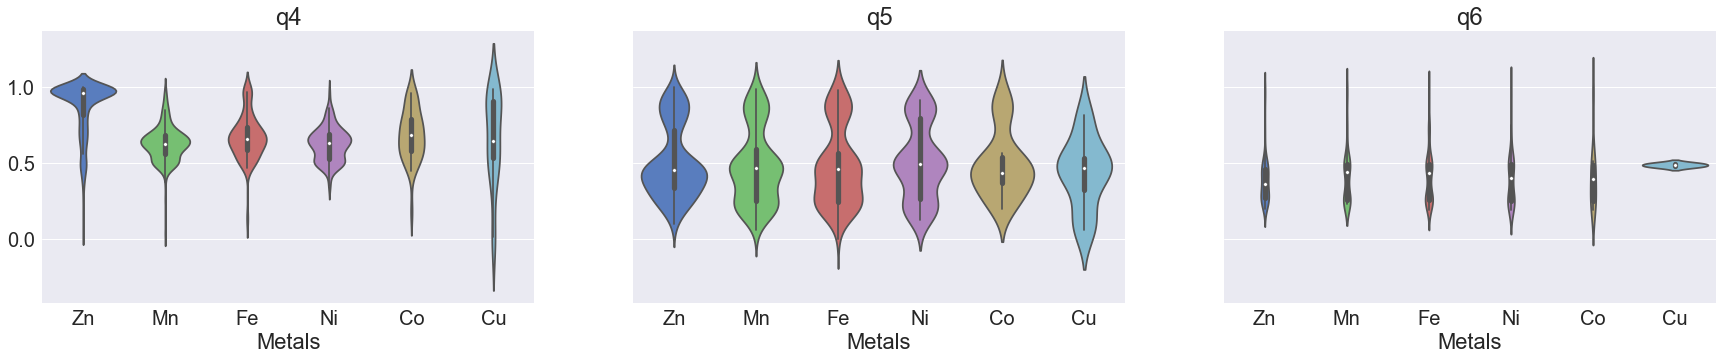

In [8]:
# tranform Dataset to pandas DataFrame
df = interactions.toPandas()

# Set fonts
sns.set(font_scale=2)

# Make subplots
fig, ax = plt.subplots(1,3, sharey = True, figsize = (30,5))

# Loop through subplots
for i in range(3):
    subplot = sns.violinplot(x="element0", y=f"q{i+4}", palette="muted", data=df, ax = ax[i])
    subplot.set(xlabel="Metals", ylabel="", title=f"q{i+4}")

## Make Violin plots for Metal-Elements distances

In [9]:
# Create dataframe subsets for elements 1-6
df_sub = [df[['element0', f'element{i}', f'distance{i}']]\
          .rename(columns={'element0':'Metal', f'element{i}':'Element', f'distance{i}':'Distance'}) \
          for i in range(1,7)]

# Vertically concating the dataframe subsets
df_concat = pd.concat(df_sub)

# Drop rows with NaN values
df_concat.dropna(inplace = True)
                  
metal_distance_widget(df_concat);

interactive(children=(Dropdown(description='Metals', options=('Zn', 'Mn', 'Fe', 'Ni', 'Co', 'Cu'), value='Zn')…

## Create subset based on Metal and q values

In [10]:
df_sub = df[df["element0"] == 'Zn']    # Filter only Zinc interactinos 
df_sub = df_sub.sort_values(["q4"], ascending = False).dropna(subset=['q4'])    #Sort by q4 values and drop NaN
df_sub = df_sub[df_sub['q5'] != np.nan]    # Remove interactions where q5 has values

df_sub.head(10)

,pdbId,q4,q5,q6,element0,groupNum0,chain0,element1,groupNum1,chain1,...,chain4,distance4,element5,groupNum5,chain5,distance5,element6,groupNum6,chain6,distance6
1116,5GRQ,0.999569,NaN,NaN,Zn,212,A,N,96,B,...,A,2.064547,None,None,None,0.0,None,None,None,0.0
1255,1ZY7,0.998688,NaN,NaN,Zn,802,B,S,451,B,...,B,2.058085,None,None,None,0.0,None,None,None,0.0
490,1OQJ,0.998562,NaN,NaN,Zn,183,A,S,113,A,...,A,2.371518,None,None,None,0.0,None,None,None,0.0
58,3ZVS,0.998459,NaN,NaN,Zn,1162,B,S,132,B,...,B,2.310095,None,None,None,0.0,None,None,None,0.0
1416,3UFF,0.998175,NaN,NaN,Zn,3,B,N,231,B,...,B,2.315903,None,None,None,0.0,None,None,None,0.0
1463,1Q08,0.998095,NaN,NaN,Zn,401,A,O,301,A,...,A,2.426980,None,None,None,0.0,None,None,None,0.0
1356,3H0N,0.997777,NaN,NaN,Zn,201,A,S,168,A,...,A,2.297602,None,None,None,0.0,None,None,None,0.0
1465,1Q08,0.997669,NaN,NaN,Zn,403,B,S,79,A,...,B,2.472048,None,None,None,0.0,None,None,None,0.0
1475,1U5K,0.997564,NaN,NaN,Zn,300,B,S,153,B,...,B,2.387050,None,None,None,0.0,None,None,None,0.0
56,3ZVS,0.997549,NaN,NaN,Zn,1160,A,S,151,A,...,A,2.346070,None,None,None,0.0,None,None,None,0.0


## Visualize Data

In [11]:
group_interaction_viewer(df_sub, 'q4');

interactive(children=(IntSlider(value=0, continuous_update=False, description='Structure', max=986), Output())…

## Terminate Spark

In [12]:
spark.stop()